In [ ]:
from __future__ import print_function
import torch
x = torch.rand(5, 3)
print(x)

# DCGAN 

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
# Root directory for dataset
dataroot = "data/Kaggle_Monkey/training"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [3]:
transform = {
    'train': transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ]),
    'val': transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])
}

In [4]:
#using torchvision ImageFolder for importing this dataset
PATH= 'data/Kaggle_Monkey/'
trainData = torchvision.datasets.ImageFolder(root=PATH+'training',transform=transform['train'])
trainDataLoader = DataLoader(trainData,batch_size=batch_size,shuffle=False,num_workers=4)
valData = torchvision.datasets.ImageFolder(root=PATH+'validation',transform=transform['val'])
valDataLoader = DataLoader(valData,batch_size=batch_size,shuffle=False,num_workers=4)

In [5]:
train_df=pd.read_csv(PATH+'training/train_labels.csv')
train_labels= train_df['label'].values
val_df=pd.read_csv(PATH+'validation/val_labels.csv')
val_labels= val_df['label'].values

In [ ]:
# fake_train_df= train_df.copy()
# # f = lambda x: 0 if x==1 else 1
# # fake_train_df = fake_train_df.replace({0:1, 1:0})

# # #df['my_column'] = df['my_column'].map(f)
# fake_train_df['n0'] = np.where(fake_train_df['n0']==1, 0, 1)
# fake_train_df['n1'] = np.where(fake_train_df['n1']==1, 0, 1)
# fake_train_df['n2'] = np.where(fake_train_df['n2']==1, 0, 1)
# fake_train_df['n3'] = np.where(fake_train_df['n3']==1, 0, 1)
# fake_train_df['n4'] = np.where(fake_train_df['n4']==1, 0, 1)
# fake_train_df['n5'] = np.where(fake_train_df['n5']==1, 0, 1)
# fake_train_df['n6'] = np.where(fake_train_df['n6']==1, 0, 1)
# fake_train_df['n7'] = np.where(fake_train_df['n7']==1, 0, 1)
# fake_train_df['n8'] = np.where(fake_train_df['n8']==1, 0, 1)
# fake_train_df['n9'] = np.where(fake_train_df['n9']==1, 0, 1)



In [ ]:
# fake_val_df= val_df.copy()
# # f = lambda x: 0 if x==1 else 1
# # fake_train_df = fake_train_df.replace({0:1, 1:0})

# # #df['my_column'] = df['my_column'].map(f)
# fake_val_df['n0'] = np.where(fake_val_df['n0']==1, 0, 1)
# fake_val_df['n1'] = np.where(fake_val_df['n1']==1, 0, 1)
# fake_val_df['n2'] = np.where(fake_val_df['n2']==1, 0, 1)
# fake_val_df['n3'] = np.where(fake_val_df['n3']==1, 0, 1)
# fake_val_df['n4'] = np.where(fake_val_df['n4']==1, 0, 1)
# fake_val_df['n5'] = np.where(fake_val_df['n5']==1, 0, 1)
# fake_val_df['n6'] = np.where(fake_val_df['n6']==1, 0, 1)
# fake_val_df['n7'] = np.where(fake_val_df['n7']==1, 0, 1)
# fake_val_df['n8'] = np.where(fake_val_df['n8']==1, 0, 1)
# fake_val_df['n9'] = np.where(fake_val_df['n9']==1, 0, 1)

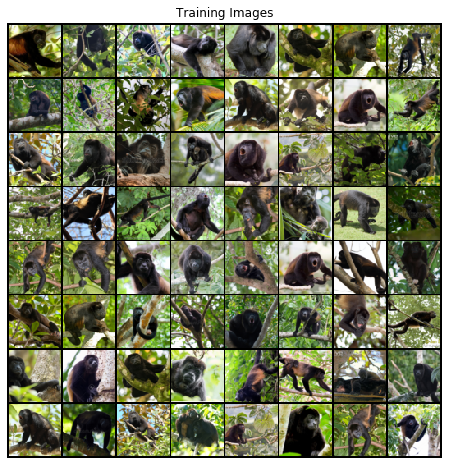

In [6]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
#using torchvision ImageFolder for importing this dataset

# dataset = dataset.ImageFolder(root=dataroot,
#                            transform=transforms.Compose([
#                                transforms.Resize(image_size),
#                                transforms.CenterCrop(image_size),
#                                transforms.ToTensor(),
#                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#                            ]))
# # Create the dataloader
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
#                                          shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(trainDataLoader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [7]:
#What each class signifies in this model from n0-n9
dfAllClasses = pd.read_csv(PATH+'monkey_labels.txt')
label = [str.strip(x) for x in list(dfAllClasses[dfAllClasses.columns[2]])]
label

['mantled_howler',
 'patas_monkey',
 'bald_uakari',
 'japanese_macaque',
 'pygmy_marmoset',
 'white_headed_capuchin',
 'silvery_marmoset',
 'common_squirrel_monkey',
 'black_headed_night_monkey',
 'nilgiri_langur']

In [9]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [11]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [12]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [13]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [14]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0
# real_train_n0_label = torch.tensor(train_df['n0'].values, device=device) #torch.tensor(list(train_labels), device=device)
# real_valid_n0_label = torch.tensor(val_df['n0'].values, device=device)
# fake_train_n0_label = torch.tensor(fake_train_df['n0'].values, device=device)
# fake_valid_n0_label = torch.tensor(fake_val_df['n0'].values, device=device)
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [15]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(trainDataLoader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(trainDataLoader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(trainDataLoader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/100][0/18]	Loss_D: 2.2586	Loss_G: 4.7436	D(x): 0.4447	D(G(z)): 0.5966 / 0.0129
[1/100][0/18]	Loss_D: 0.4614	Loss_G: 10.6270	D(x): 0.9320	D(G(z)): 0.2623 / 0.0000
[2/100][0/18]	Loss_D: 0.1534	Loss_G: 15.8012	D(x): 0.8804	D(G(z)): 0.0002 / 0.0000
[3/100][0/18]	Loss_D: 0.0533	Loss_G: 24.3683	D(x): 0.9515	D(G(z)): 0.0000 / 0.0000
[4/100][0/18]	Loss_D: 3.5940	Loss_G: 20.9141	D(x): 0.2534	D(G(z)): 0.0000 / 0.0000
[5/100][0/18]	Loss_D: 0.6483	Loss_G: 9.6864	D(x): 0.7211	D(G(z)): 0.0002 / 0.0002
[6/100][0/18]	Loss_D: 0.8123	Loss_G: 6.3148	D(x): 0.5974	D(G(z)): 0.0025 / 0.0039
[7/100][0/18]	Loss_D: 0.4527	Loss_G: 5.4534	D(x): 0.7482	D(G(z)): 0.0531 / 0.0123
[8/100][0/18]	Loss_D: 0.4541	Loss_G: 4.5765	D(x): 0.8628	D(G(z)): 0.1835 / 0.0352
[9/100][0/18]	Loss_D: 0.5342	Loss_G: 4.8110	D(x): 0.7047	D(G(z)): 0.0455 / 0.0221
[10/100][0/18]	Loss_D: 0.5094	Loss_G: 4.4524	D(x): 0.7204	D(G(z)): 0.0730 / 0.0454
[11/100][0/18]	Loss_D: 0.2813	Loss_G: 3.7192	D(x): 0.8166	D(G(z)): 

[99/100][0/18]	Loss_D: 0.6478	Loss_G: 6.3533	D(x): 0.9199	D(G(z)): 0.3593 / 0.0031


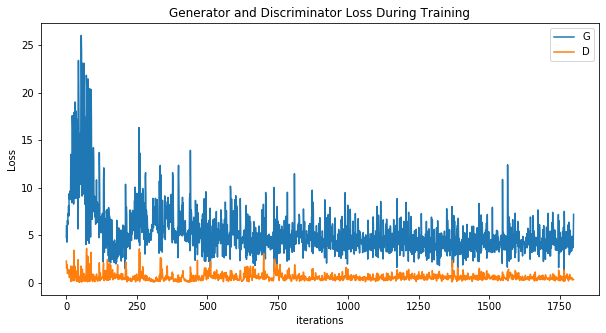

In [16]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


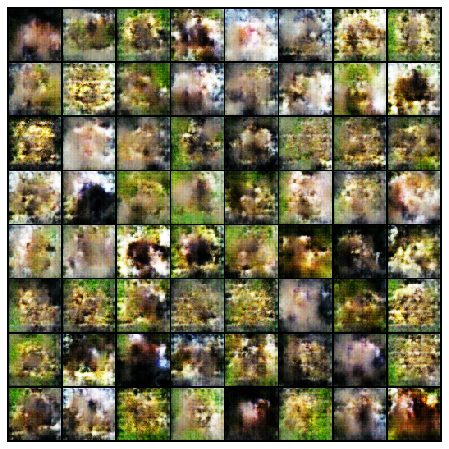

In [17]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

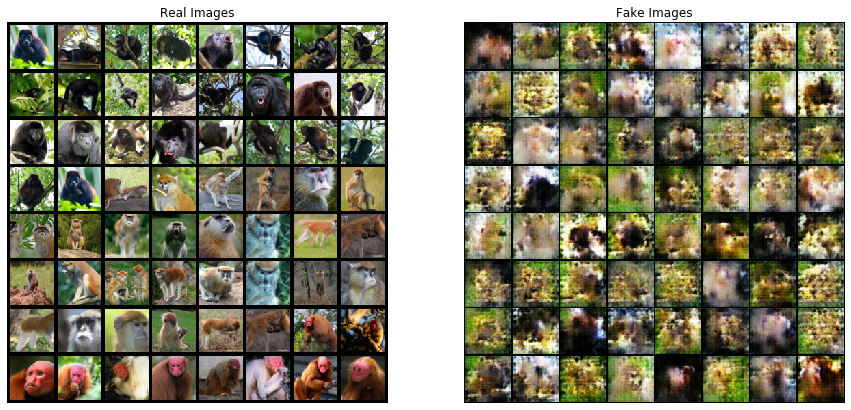

In [19]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(valDataLoader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
## generating images

In [28]:
def one_hot(target):
    # One hot encoding buffer that you create out of the loop and just keep reusing
    target_onehot = torch.FloatTensor(target.size(0), 10)
    
    #target_onehot = torch.FloatTensor(opt.batchSize, num_classes)
    # In your for loop
    target_onehot.zero_()
    target_onehot.scatter_(1, target, 1)
    return target_onehot  

In [29]:
the_class=0
num_classes=10

In [30]:
output_folder='gan_generate_output'

In [32]:
from torch.autograd import Variable

In [33]:
fixed_noise = torch.FloatTensor(batch_size, nz, 1, 1).normal_(0, 1)

ones = torch.ones(batch_size,1)
fixed_class_vec = torch.mul(ones,the_class)
class_onehot = one_hot(fixed_class_vec.long())
class_onehot.unsqueeze_(2).unsqueeze_(3)

fixed_noise = torch.cat([fixed_noise,class_onehot],1)
fixed_noise = Variable(fixed_noise)

fake = netG(fixed_noise)
fake2 = fake.data
fake2 = fake.data[:,0:nc,:,:]
# if opt.nc == 1:
#     fake2 = fake2.unsqueeze(1)
vutils.save_image(fake2,
        '%s/final_samples_epoch_%03d.png' % (outf, opt.the_class),
        normalize=True)

RuntimeError: Given transposed=1, weight of size 100 512 4 4, expected input[64, 110, 1, 1] to have 100 channels, but got 110 channels instead